In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
#install if not available
! pip install nltk

print("***** Dependency library installed *****")

***** Dependency library installed *****


In [27]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import concatenate, Activation, Conv1D, Conv2D, Softmax, Multiply, Add, Flatten, Dropout, Dense, Reshape, Lambda, BatchNormalization, Embedding, ZeroPadding1D, AveragePooling1D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.backend import squeeze, sum, tile, clear_session
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model, to_categorical
import csv
import nltk
from nltk.corpus import stopwords

import re
import functools

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle

from functools import wraps


featureSize = 100
denseLayerNb = 5
MAX_NUM_WORDS = 1000
MAX_SEQUENCE_LENGTH = 100
classNb = 2
dataWords = 100
batchSize = 128
weight_path = '/content/drive/My Drive/NN_Project/data/weights/'
train_dest = '/content/drive/My Drive/NN_Project/new_data/'
dict_dir = '/content/drive/My Drive/NN_Project/data/glove.42B.300d.txt'

print("***** Libraries imported and initilised values *****")

***** Libraries imported and initilised values *****


In [5]:
#data import and process
nltk.download('stopwords')
stop = set(stopwords.words('english'))

embeddings_index = {}
f = open(dict_dir)
for line in f:
    values = line.split(' ')
    word = values[0] 
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = coefs
f.close()

trainLabel=[]
trainData = []
with open(train_dest + 'True.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
      field_names_list = row
      trainLabel.append("1")
      if(len(field_names_list) > 0):
        trainData.append(field_names_list[1].replace("...", " "))
with open(train_dest + 'Fake.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
      field_names_list = row
      trainLabel.append("0")
      if(len(field_names_list) > 0):
        trainData.append(field_names_list[1].replace("...", " "))


lines_without_stopwords=[] 
for line in trainData: 
  line = line.lower()
  line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE)
  new_line=[]
  for word in line_by_words:
    if word not in stop:
      new_line.append(word)
  lines_without_stopwords.append(new_line)
texts = lines_without_stopwords

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(trainLabel))
data, labels = shuffle(data, labels)

EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("***** Data processed successfully *****")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
***** Data processed successfully *****


In [28]:
#initilise utility functions

def compose(*functions):
    return functools.reduce(lambda f, g: lambda x: g(f(x)), functions, lambda x: x)

def NormalisationAndActivation():
    return compose(
        BatchNormalization(),
        Activation('relu'))

def convertFeature(*args, **kwargs):
    return translationConvolutionWrapper(*args, **kwargs)

def convolutionWrapper(*args, **kwargs):
    ncKwargs = {}
    ncKwargs.update(kwargs)
    return Conv1D(*args, **ncKwargs)

def denseWrapper(*args, **kwargs):
    ndKwargs = {}
    ndKwargs.update(kwargs)
    return Dense(*args, **ndKwargs)

def translationConvolutionWrapper(*args, **kwargs):
    cfKwargs = {'kernel_size' : 1}
    cfKwargs['filters'] = featureSize
    cfKwargs['strides'] = 1
    cfKwargs['padding'] = 'valid'
    cfKwargs.update(kwargs)
    return convolutionWrapper(*args, **cfKwargs)

def denseConvolutionWrapper(*args, **kwargs):
    dcKwargs = {'kernel_size' : 3}
    dcKwargs['filters'] = featureSize
    dcKwargs['strides'] = 1
    dcKwargs['padding'] = 'valid'
    dcKwargs.update(kwargs)
    return compose(ZeroPadding1D(padding=1),
                   convolutionWrapper(*args, **dcKwargs))

def denseAvgPool(*args, **kwargs):
    dapKwargs = {'pool_size' : 3}
    dapKwargs['strides'] = 2
    dapKwargs['padding'] = 'valid'
    dapKwargs.update(kwargs)
    return compose(ZeroPadding1D(padding=1),
                   AveragePooling1D(*args, **dapKwargs))

def groupConvolution(*args, **kwargs):
    gcKwargs = {'kernel_size' : (1, 1)}
    gcKwargs['filters'] = featureSize
    gcKwargs['strides'] = 1
    gcKwargs['padding'] = 'valid'
    gcKwargs.update(kwargs)
    return Conv2D(*args, **gcKwargs)

def attention_function_1(*args, **kwargs):
    af1Kwargs = {'units' : 64}
    af1Kwargs.update(kwargs)
    return compose(denseWrapper(*args, **af1Kwargs),
                   Activation('relu'))

def attention_function_2(*args, **kwargs):
    af2Kwargs = {'units' : 32}
    af2Kwargs.update(kwargs)
    return compose(denseWrapper(*args, **af2Kwargs),
                   Activation('relu'))

def attention_function_3(*args, **kwargs):
    af3Kwargs = {'units' : 4 + denseLayerNb - 1}
    af3Kwargs.update(kwargs)
    return compose(denseWrapper(*args, **af3Kwargs),
                   Activation('relu'))

def final_dropout_1(*args, **kwargs):
    fc1Kwargs = {'units' : 64}
    fc1Kwargs.update(kwargs)
    return compose(Dropout(rate=0.5),
                   denseWrapper(*args, **fc1Kwargs),
                   Activation('relu'))

def final_dropout_2(*args, **kwargs):
    fc2Kwargs = {'units' : classNb}
    fc2Kwargs.update(kwargs)
    return compose(Dropout(rate=0.5),
                   Dense(*args, **fc2Kwargs),
                   Activation('relu'))


def slice(x, h1, h2, w1, w2):
    return x[:, h1 : h2, w1 : w2, :]

def sliceChannel(x, c1, c2):
    return x[:, :, c1 : c2]

def sliceWords(x, w1, w2):
    return x[:, w1 : w2, :]

def attentionGroup(inputs, wordsLength):
    outputs = inputs
    for _ in range(2):
        outputs = Reshape((outputs.shape[1], 4 + denseLayerNb - 1, featureSize))(outputs)
        L = [Lambda(slice, arguments={'h1':0, 'h2':wordsLength, 'w1':i, 'w2':i + 1})(outputs) for i in range(4 + denseLayerNb - 1)]
        L = [groupConvolution()(e) for e in L]
        L = [Lambda(lambda z : squeeze(z, - 2))(e) for e in L]
        outputs = concatenate(L)
        outputs = NormalisationAndActivation()(outputs)
    return outputs

def sliceAndConcantinate(inputs, wordsLength):
    L = [Lambda(sliceWords, arguments={'w1': i, 'w2': i + 1})(inputs) for i in range(wordsLength)]
    L = [attention_function_1()(e) for e in L]
    L = [attention_function_2()(e) for e in L]
    L = [attention_function_3()(e) for e in L]
    L = [Reshape((1, 4 + denseLayerNb - 1))(e) for e in L]
    outputs = concatenate(L, axis=-2)
    return outputs

def generateAttentions(inputs):
    outputsList = [Lambda(sliceChannel, arguments={'c1': i, 'c2': i + 1})(inputs) for i in range(4 + denseLayerNb - 1)]
    outputsList = [Lambda(tile, arguments={'n' : (1, 1, featureSize)})(e) for e in outputsList]
    return outputsList

def linearWithDropout(inputs, classNb):
    outputs = Flatten()(inputs)
    outputs = compose(final_dropout_1(),
                      final_dropout_2(units=classNb))(outputs)
    return outputs

def preProcess(inputs):
    outputs = compose(Activation('relu'),
                   Softmax())(inputs)
    return outputs

print("***** utility functions library initilised *****")

***** utility functions library initilised *****


In [29]:
#Model definition 

def gen_trans_layer(inputs):
    outputs1 = convertFeature()(inputs)
    outputs = NormalisationAndActivation()(outputs1)
    outputs2 = translationConvolutionWrapper()(outputs)
    outputs = NormalisationAndActivation()(outputs2)
    outputs3 = translationConvolutionWrapper()(outputs)
    outputs = NormalisationAndActivation()(outputs3)
    outputs4 = denseConvolutionWrapper()(outputs)
    outputs = concatenate([outputs4, outputs1, outputs2, outputs3])
    outputs = NormalisationAndActivation()(outputs)
    return outputs


def gen_dense_layer(inputs):
    outputs = inputs
    for _ in range(denseLayerNb - 1):
        outputs1 = denseAvgPool()(outputs)
        outputs2 = denseConvolutionWrapper()(outputs1)
        outputs = concatenate([outputs2, outputs1])
        outputs = NormalisationAndActivation()(outputs)
    return outputs


def gen_attention_layer(outputs, finalWordsLength):
    outputs = attentionGroup(outputs, finalWordsLength)
    xList = [Lambda(sliceChannel, arguments={'c1': i * featureSize, 'c2': (i + 1) * featureSize})(outputs) for i in range(4 + denseLayerNb - 1)]
    outputsList = [Lambda(sum, arguments={'axis':-1, 'keepdims':True})(e) for e in xList]
    outputs = concatenate(outputsList)
    outputs = sliceAndConcantinate(outputs, finalWordsLength)
    outputs = preProcess(outputs)
    aList = generateAttentions(outputs)
    reweightedList = [Multiply()([x, a]) for x, a in zip(xList, aList)]
    outputs = Add()(reweightedList)
    return outputs

def gen_classification_layer(outputs):
    outputs = linearWithDropout(outputs, classNb)
    outputs = preProcess(outputs)
    return outputs


def DenseNetFeatureAttentionModel(inputs, ebdMatrix, dataWords, classNb):
    finalWordsLength = dataWords
    layersNb = denseLayerNb - 1
    pad = 1
    winSize = 3
    stride = 2
    for _ in range(layersNb):
        finalWordsLength = (finalWordsLength + pad * 2 - winSize) // stride + 1

    outputs = Embedding(input_length=dataWords, input_dim=np.shape(ebdMatrix)[0], output_dim=np.shape(ebdMatrix)[1], mask_zero = False, trainable= False)(inputs)
    outputs = gen_trans_layer(outputs)
    outputs = gen_dense_layer(outputs)
    outputs = gen_attention_layer(outputs, finalWordsLength)
    outputs = gen_classification_layer(outputs)

    return Model(inputs, outputs)

print("***** model initilised *****")

***** model initilised *****


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     300300      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 100)     30100       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 100)     400         conv1d[0][0]                     
______________________________________________________________________________________________

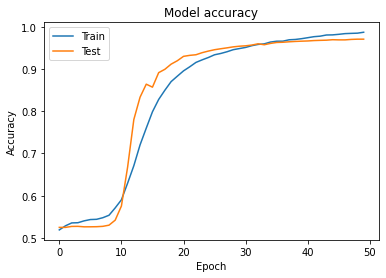

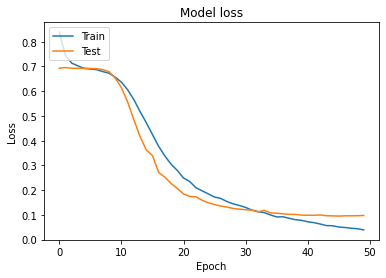

In [30]:
#training
clear_session()
data, labels = shuffle(data, labels)

inputs = Input(shape=(dataWords, ))

model = DenseNetFeatureAttentionModel(inputs, embedding_matrix, dataWords, classNb)

model.summary()
opt = Nadam(lr=0.00001, schedule_decay=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
file_path = weight_path + "100ws-adam-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoints = ModelCheckpoint(file_path,monitor='val_acc',verbose=1,save_best_only=True,mode='max')
callback_list = [checkpoints]
history = model.fit(data, labels, validation_split=0.4, epochs=50, batch_size=batchSize, callbacks=callback_list, verbose=1, shuffle=True)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('news_accuracy_adam_100ws.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('news_loss_adam_100ws.png')
plt.show()